# Introduction to zfit

In this notebook, we will have a walk through the main components of zfit and their features. Especially the extensive model building part will be discussed separately.

## Data

This component in general plays a minor role in zfit: it is mostly to provide a unified interface for data.

Preprocessing is therefore not part of zfit and should be done beforehand. Python offers many great possibilities to do so (e.g. Pandas).

zfit `Data` can load data from various sources, most notably from Numpy, Pandas DataFrame, TensorFlow Tensor and ROOT (using uproot). It is also possible, for convenience, to convert it directly `to_pandas`. The constructors are named `from_numpy`, `from_root` etc.

In [1]:
import zfit
from zfit import z
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

A `Data` needs not only the data itself but also the observables: the human readable string identifiers of the axes (corresponding to "columns" of a Pandas DataFrame). It is convenient to define the `Space` not only with the observable but also with a limit: this can directly be re-used as the normalization range in the PDF.

First, let's define our observables

In [2]:
obs = zfit.Space('obs1', (-5, 10))

This `Space` has limits. Next to the effect of handling the observables, we can also play with the limits: multiple `Spaces` can be added to provide disconnected ranges. More importantly, `Space` offers functionality:
- limit1d: return the lower and upper limit in the 1 dimensional case (raises an error otherwise)
- rect_limits: return the n dimensional limits
- area(): calculate the area (e.g. distance between upper and lower)
- inside(): return a boolean Tensor corresponding to whether the value is _inside_ the `Space`
- filter(): filter the input values to only return the one inside

In [3]:
size_normal = 10000
data_normal_np = np.random.normal(size=size_normal, scale=2)

data_normal = zfit.Data.from_numpy(obs=obs, array=data_normal_np)

The main functionality is
- nevents: attribute that returns the number of events in the object
- data_range: a `Space` that defines the limits of the data; if outside, the data will be cut
- n_obs: defines the number of dimensions in the dataset
- with_obs: returns a subset of the dataset with only the given obs
- weights: event based weights

Furthermore, `value` returns a Tensor with shape `(nevents, n_obs)`.

To retrieve values, in general `z.unstack_x(data)` should be used; this returns a single Tensor with shape (nevents) or a list of tensors if `n_obs` is larger then 1.

In [4]:
print(f"We have {data_normal.nevents} events in our dataset with the minimum of {np.min(data_normal.unstack_x())}")  # remember! The obs cut out some of the data

We have 9946 events in our dataset with the minimum of -4.978826801974078

In [5]:
data_normal.n_obs

1

## Model

Building models is by far the largest part of zfit. We will therefore cover an essential part, the possibility to build custom models, in an extra chapter. Let's start out with the idea that you define your parameters and your observable space; the latter is the expected input data.

There are two types of models in zfit:
- functions, which are rather simple and "underdeveloped"; their usage is often not required.
- PDF that are function which are normalized (over a specified range); this is the main model and is what we gonna use throughout the tutorials.

A PDF is defined by

\begin{align}
\mathrm{PDF}_{f(x)}(x; \theta) = \frac{f(x; \theta)}{\int_{a}^{b} f(x; \theta)}
\end{align}

where a and b define the normalization range (`norm_range`), over which (by inserting into the above definition) the integral of the PDF is unity.

zfit has a modular approach to things and this is also true for models. While the normalization itself (e.g. what are parameters, what is normalized data) will already be pre-defined in the model, models are composed of functions that are transparently called inside. For example, a Gaussian would usually be implemented by writing a Python function `def gauss(x, mu, sigma)`, which does not care about the normalization and then be wrapped in a PDF, where the normalization and what is a parameter is defined.

In principle, we can go far by using simply functions (e.g. [TensorFlowAnalysis/AmpliTF](https://github.com/apoluekt/AmpliTF) by Anton Poluektov uses this approach quite successfully for Amplitude Analysis), but this design has limitations for a more general fitting library such as zfit (or even [TensorWaves](https://github.com/ComPWA/tensorwaves), being built on top of AmpliTF).
The main thing is to keep track of the different ordering of the data and parameters, especially the dependencies. 


Let's create a simple Gaussian PDF. We already defined the `Space` for the data before, now we only need the parameters. This are a different object than a `Space`.

### Parameter
A `Parameter` (there are different kinds actually, more on that later) takes the following arguments as input:
`Parameter(human readable name, initial value[, lower limit, upper limit])` where the limits are recommended but not mandatory. Furthermore, `step_size` can be given (which is useful to be around the given uncertainty, e.g. for large yields or small values it can help a lot to set this). Also, a `floating` argument is supported, indicating whether the parameter is allowed to float in the fit or not (just omitting the limits does _not_ make a parameter constant).

Parameters have a unique name. This is served as the identifier for e.g. fit results. However, a parameter _cannot_ be retrieved by its string identifier (its name) but the object itself should be used. In places where a parameter maps to something, the object itself is needed, not its name.

In [6]:
mu = zfit.Parameter('mu', 1, -3, 3, step_size=0.2)
sigma_num = zfit.Parameter('sigma42', 1, 0.1, 10, floating=False)

These attributes can be changed:

In [7]:
print(f"sigma is float: {sigma_num.floating}")
sigma_num.floating = True
print(f"sigma is float: {sigma_num.floating}")

sigma is float: False

sigma is float: True

*PITFALL NOTEBOOKS: since the parameters have a unique name, a second parameter with the same name cannot be created; the behavior is undefined and therefore it raises an error.
While this does not pose a problem in a normal Python script, it does in a Jupyter-like notebook, since it is an often practice to "rerun" a cell as an attempt to "reset" things. Bear in mind that this does not make sense, from a logic point of view. The parameter already exists. Best practice: write a small wrapper, do not rerun the parameter creation cell or simply rerun the notebook (restart kernel & run all). For further details, have a look at the discussion and arguments [here](https://github.com/zfit/zfit/issues/186)*

Now we have everything to create a Gaussian PDF:

In [8]:
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma_num)

Since this holds all the parameters and the observables are well defined, we can retrieve them

In [9]:
gauss.n_obs  # dimensions

1

In [10]:
gauss.obs

('obs1',)

In [11]:
gauss.space

<zfit Space obs=('obs1',), axes=(0,), limits=(array([[-5.]]), array([[10.]]))>

In [12]:
gauss.norm_range

<zfit Space obs=('obs1',), axes=(0,), limits=(array([[-5.]]), array([[10.]]))>

As we've seen, the `obs` we defined is the `space` of Gauss: this acts as the default limits whenever needed (e.g. for sampling). `gauss` also has a `norm_range`, which equals by default as well to the `obs` given, however, we can explicitly change that with `set_norm_range`.

We can also access the parameters of the PDF in two ways, depending on our intention: 
either by _name_ (the parameterization name, e.g. `mu` and `sigma`, as defined in the `Gauss`), which is useful if we are interested in the parameter that _describes_ the shape

In [13]:
gauss.params

OrderedDict([('mu', <zfit.Parameter 'mu' floating=True value=1>),
             ('sigma', <zfit.Parameter 'sigma42' floating=True value=1>)])

or to retrieve all the parameters that the PDF depends on. As this now may sounds trivial, we will see later that models can depend on other models (e.g. sums) and parameters on other parameters. There is one function that automatically retrieves _all_ dependencies, `get_params`. It takes three arguments to filter:
- floating: whether to filter only floating parameters, only non-floating or don't discriminate
- is_yield: if it is a yield, or not a yield, or both
- extract_independent: whether to recursively collect all parameters. This, and the explanation for why independent, can be found later on in the `Simultaneous` tutorial.

Usually, the default is exactly what we want if we look for _all free parameters that this PDF depends on_.

In [14]:
gauss.get_params()

OrderedSet([<zfit.Parameter 'mu' floating=True value=1>, <zfit.Parameter 'sigma42' floating=True value=1>])

The difference will also be clear if we e.g. use the same parameter twice:

In [15]:
gauss_only_mu = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=mu)
print(f"params={gauss_only_mu.params}")
print(f"get_params={gauss_only_mu.get_params()}")

params=OrderedDict([('mu', <zfit.Parameter 'mu' floating=True value=1>), ('sigma', <zfit.Parameter 'mu' floating=True value=1>)])

get_params=OrderedSet([<zfit.Parameter 'mu' floating=True value=1>])

## Functionality

PDFs provide a few useful methods. The main features of a zfit PDF are:

- `pdf`: the normalized value of the PDF. It takes an argument `norm_range` that can be set to `False`, in which case we retrieve the unnormalized value
- `integrate`: given a certain range, the PDF is integrated. As `pdf`, it takes a `norm_range` argument that integrates over the unnormalized `pdf` if set to `False`
- `sample`: samples from the pdf and returns a `Data` object

In [16]:
integral = gauss.integrate(limits=(-1, 3))  # corresponds to 2 sigma integral
integral

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.95449974])>

### Tensors

As we see, many zfit functions return Tensors. This is however no magical thing! If we're outside of models, than we can always safely convert them to a numpy array by calling `zfit.run(...)` on it (or any structure containing potentially multiple Tensors). However, this may not even be required often! They can be added just like numpy arrays and interact well with Python and Numpy:

In [17]:
np.sqrt(integral)

array([0.97698502])

They also have shapes, dtypes, can be slices etc. So do not convert them except you need it. More on this can be seen in the talk later on about zfit and TensorFlow 2.0.

In [18]:
sample = gauss.sample(n=1000)  # default space taken as limits
sample

In [19]:
sample.unstack_x()[:10]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([3.53428249, 2.21623497, 0.74033309, 0.94986531, 1.16898151,
       1.3350581 , 0.2433266 , 1.68229119, 1.81464923, 1.35160915])>

In [20]:
sample.n_obs

1

In [21]:
sample.obs

('obs1',)

We see that sample returns also a zfit `Data` object with the same space as it was sampled in. This can directly be used e.g.

In [22]:
probs = gauss.pdf(sample)
probs[:10]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.01607914, 0.19041445, 0.38571675, 0.39844123, 0.3932869 ,
       0.37716576, 0.29962732, 0.31609921, 0.28628564, 0.37502859])>

**NOTE**: In case you want to do this repeatedly (e.g. for toy studies), there is a way more efficient way (see later on)

## Plotting

so far, we have a dataset and a PDF. Before we go for fitting, we can make a plot. This functionality is not _directly_ provided in zfit (but can be added to [zfit-physics](https://github.com/zfit/zfit-physics)). It is however simple enough to do it:

In [23]:
def plot_model(model, data, scale=1, plot_data=True):  # we will use scale later on

    nbins = 50

    lower, upper = data.data_range.limit1d
    x = tf.linspace(lower, upper, num=1000)  # np.linspace also works
    y = model.pdf(x) * size_normal / nbins * data.data_range.area()
    y *= scale
    plt.plot(x, y)
    data_plot = zfit.run(z.unstack_x(data))  # we could also use the `to_pandas` method
    if plot_data:
        plt.hist(data_plot, bins=nbins)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:5: UserWarning: The function <function Space.limit1d at 0x7f913a2d66a8> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('obs1',), axes=(0,), limits=(array([[-5.]]), array([[10.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:7: UserWarning: The function <function Space.area at 0x7f913a2d6488> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('obs1',), axes=(0,), limits=(array([[-5.]]), array([[10.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.


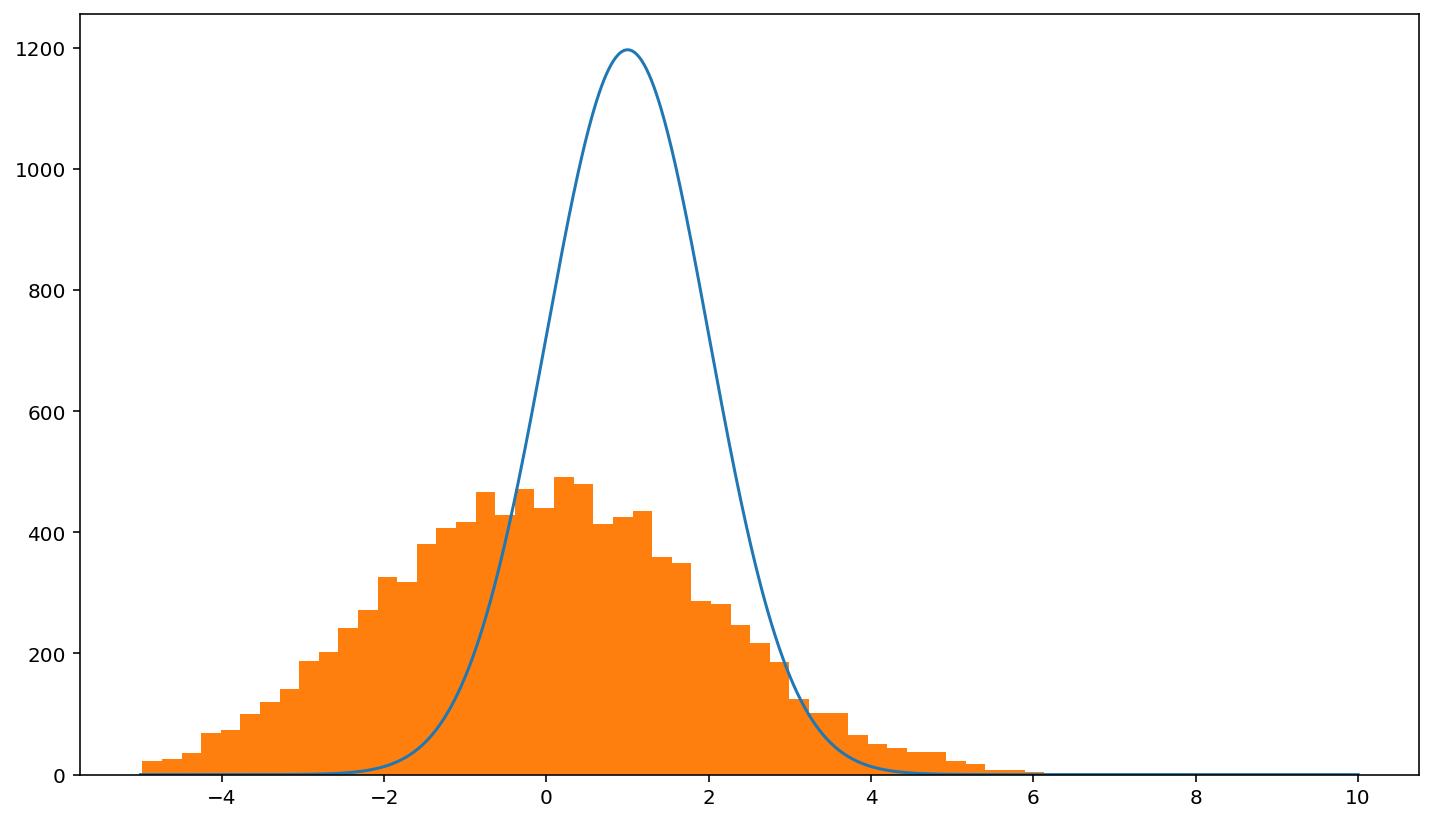

In [24]:
plot_model(gauss, data_normal)

We can of course do better (and will see that later on, continuously improve the plots), but this is quite simple and gives us the full power of matplotlib.

### Different models

zfit offers a selection of predefined models (and extends with models from zfit-physics that contain physics specific models such as ARGUS shaped models).

In [25]:
print(zfit.pdf.__all__)

['BasePDF', 'BaseFunctor', 'Exponential', 'CrystalBall', 'DoubleCB', 'Gauss', 'Uniform', 'TruncatedGauss', 'WrapDistribution', 'Cauchy', 'Chebyshev', 'Legendre', 'Chebyshev2', 'Hermite', 'Laguerre', 'RecursivePolynomial', 'ProductPDF', 'SumPDF', 'GaussianKDE1DimV1', 'ZPDF', 'SimplePDF', 'SimpleFunctorPDF']

To create a more realistic model, we can build some components for a mass fit with a
- signal component: CrystalBall
- combinatorial background: Exponential
- partial reconstructed background on the left: Kernel Density Estimation

In [26]:
mass_obs = zfit.Space('mass', (0, 1000))

In [27]:
# Signal component

mu_sig = zfit.Parameter('mu_sig', 400, 100, 600)
sigma_sig = zfit.Parameter('sigma_sig', 50, 1, 100)
alpha_sig = zfit.Parameter('alpha_sig', 300, 100, 400)
n_sig = zfit.Parameter('n sig', 4, 0.1, 30)
signal = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_sig, sigma=sigma_sig, alpha=alpha_sig, n=n_sig)

In [28]:
# combinatorial background

lam = zfit.Parameter('lambda', -0.01, -0.05, -0.001)
comb_bkg = zfit.pdf.Exponential(lam, obs=mass_obs)

In [29]:
part_reco_data = np.random.normal(loc=200, scale=150, size=700)
part_reco_data = zfit.Data.from_numpy(obs=mass_obs, array=part_reco_data)  # we don't need to do this but now we're sure it's inside the limits

part_reco = zfit.pdf.GaussianKDE1DimV1(obs=mass_obs, data=part_reco_data, bandwidth='adaptive')

## Composing models

We can also compose multiple models together. Here we'll stick to one dimensional models, the extension to multiple dimensions is explained in the "custom models tutorial".

Here we will use a `SumPDF`. This takes pdfs and fractions. If we provide n pdfs and:
- n - 1 fracs: the nth fraction will be 1 - sum(fracs)
- n fracs: no normalization attempt is done by `SumPDf`. If the fracs are not implicitly normalized, this can lead to bad fitting
  behavior if there is a degree of freedom too much
  


In [30]:
sig_frac = zfit.Parameter('sig_frac', 0.3, 0, 1)
comb_bkg_frac = zfit.Parameter('comb_bkg_frac', 0.25, 0, 1)
model = zfit.pdf.SumPDF([signal, comb_bkg, part_reco], [sig_frac, comb_bkg_frac])

In order to have a corresponding data sample, we can just create one. Since we want to fit to this dataset later on, we will create it with slightly different values. Therefore, we can use the ability of a parameter to be set temporarily to a certain value with

In [31]:
print(f"before: {sig_frac}")
with sig_frac.set_value(0.25):
    print(f"new value: {sig_frac}")
print(f"after 'with': {sig_frac}")

before: <zfit.Parameter 'sig_frac' floating=True value=0.3>

new value: <zfit.Parameter 'sig_frac' floating=True value=0.25>

after 'with': <zfit.Parameter 'sig_frac' floating=True value=0.3>

While this is useful, it does not fully scale up. We can use the `zfit.param.set_values` helper therefore.
(_Sidenote: instead of a list of values, we can also use a `FitResult`, the given parameters then take the value from the result_)

In [32]:
with zfit.param.set_values([mu_sig, sigma_sig, sig_frac, comb_bkg_frac, lam], [370, 34, 0.18, 0.15, -0.006]):
    data = model.sample(n=10000)

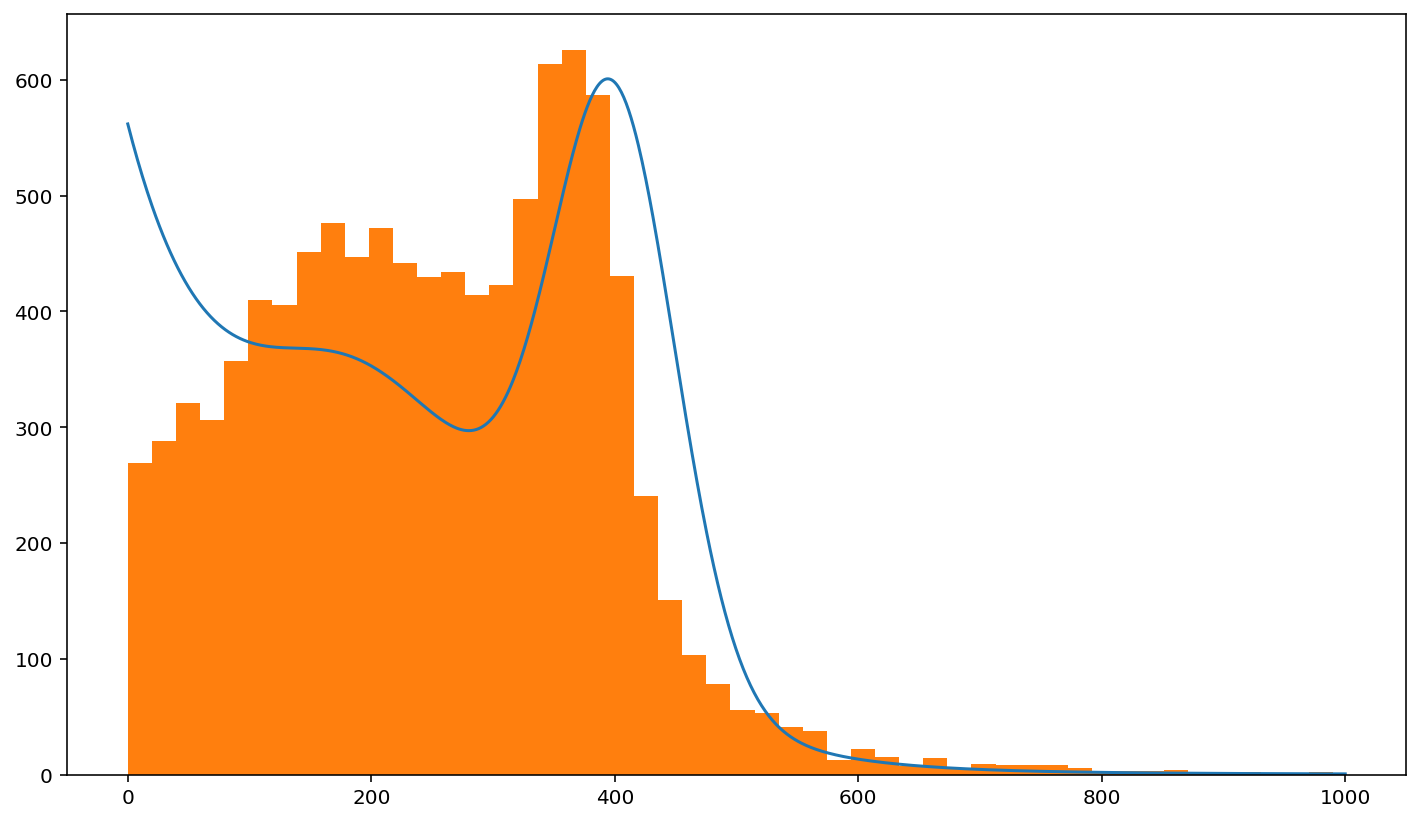

In [33]:
plot_model(model, data);

Plotting the components is not difficult now: we can either just plot the pdfs separately (as we still can access them) or in a generalized manner by accessing the `pdfs` attribute:

In [34]:
def plot_comp_model(model, data):
    for mod, frac in zip(model.pdfs, model.params.values()):
        plot_model(mod, data, scale=frac, plot_data=False)
    plot_model(model, data)

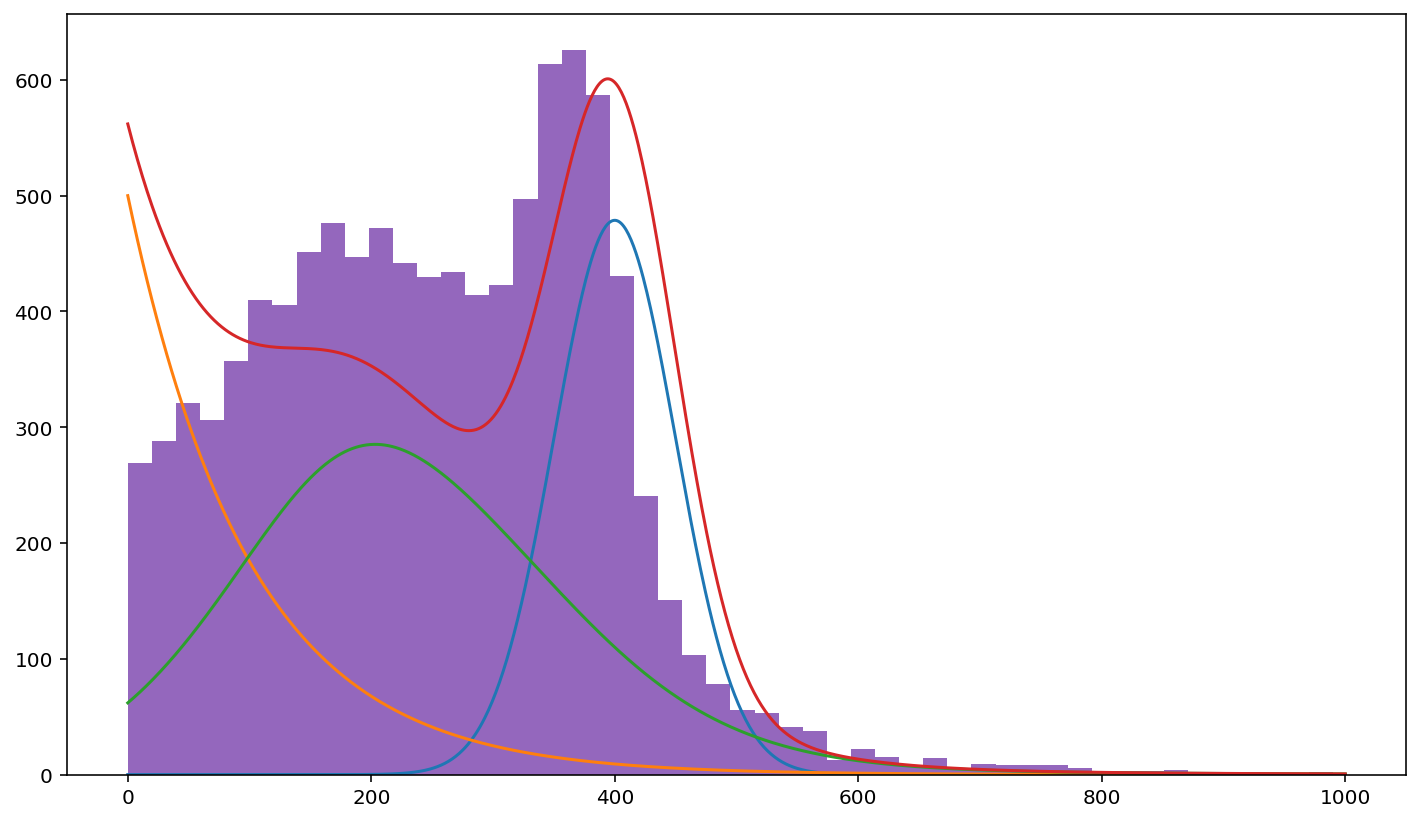

In [35]:
plot_comp_model(model, data)

Now we can add legends etc. Btw, did you notice that actually, the `frac` params are zfit `Parameters`? But we just used them as if they were Python scalars and it works.

In [36]:
print(model.params)

OrderedDict([('frac_0', <zfit.Parameter 'sig_frac' floating=True value=0.3>), ('frac_1', <zfit.Parameter 'comb_bkg_frac' floating=True value=0.25>), ('frac_2', <zfit.ComposedParameter 'Composed_autoparam_2' params=OrderedDict([('param_0', <zfit.Parameter 'sig_frac' floating=True value=0.3>), ('param_1', <zfit.Parameter 'comb_bkg_frac' floating=True value=0.25>)]) value=0.45>)])

### Extended PDFs

So far, we have only looked at normalized PDFs that do contain information about the shape but not about the _absolute_ scale. We can make a PDF extended by adding a yield to it.

The behavior of the new, extended PDF does **NOT change**, any methods we called before will act the same. Only exception, some may require an argument _less_ now. All the methods we used so far will return the same values. What changes is that the flag `model.is_extended` now returns `True`. Furthermore, we have now a few more methods that we can use which would have raised an error before:
- `get_yield`: return the yield parameter (notice that the yield is _not_ added to the shape parameters `params`)
- `ext_{pdf,integrate}`: these methods return the same as the versions used before, however, multiplied by the yield
- `sample` is still the same, but does not _require_ the argument `n` anymore. By default, this will now equal to a _poissonian sampled_ n around the yield.

The `SumPDF` now does not strictly need `fracs` anymore: if _all_ input PDFs are extended, the sum will be as well and use the (normalized) yields as fracs

The preferred way to create an extended PDf is to use `PDF.create_extended(yield)`. However, since this relies on copying the PDF (which may does not work for different reasons), there is also a `set_yield(yield)` method that sets the yield in-place. This won't lead to ambiguities, as everything is supposed to work the same.

In [37]:
yield_model = zfit.Parameter('yield_model', 10000, 0, 20000, step_size=10)
model_ext = model.create_extended(yield_model)

alternatively, we can create the models as extended and sum them up

In [38]:
sig_yield = zfit.Parameter('sig_yield', 2000, 0, 10000, step_size=1)
sig_ext = signal.create_extended(sig_yield)

comb_bkg_yield = zfit.Parameter('comb_bkg_yield', 6000, 0, 10000, step_size=1)
comb_bkg_ext = comb_bkg.create_extended(comb_bkg_yield)

part_reco_yield = zfit.Parameter('part_reco_yield', 2000, 0, 10000, step_size=1)
part_reco.set_yield(part_reco_yield)  # unfortunately, `create_extended` does not work here. But no problem, it won't change anyting.
part_reco_ext = part_reco

In [39]:
model_ext_sum = zfit.pdf.SumPDF([sig_ext, comb_bkg_ext, part_reco_ext])

# Loss

A loss combines the model and the data, for example to build a likelihood. Furthermore, it can contain constraints, additions to the likelihood. Currently, if the `Data` has weights, these are automatically taken into account.

In [40]:
nll_gauss = zfit.loss.UnbinnedNLL(gauss, data_normal)

The loss has several attributes to be transparent to higher level libraries. We can calculate the value of it using `value`.

In [41]:
nll_gauss.value()

<tf.Tensor: shape=(), dtype=float64, numpy=33016.127669195615>

Notice that due to graph building, this will take significantly longer on the first run. Rerun the cell above and it will be way faster.



Furthermore, the loss also provides a possibility to calculate the gradients or, often used, the value and the gradients.

We can access the data and models (and possible constraints)

In [42]:
nll_gauss.model

[<zfit.Gauss  params=[mu, sigma42] dtype=float64>0]

In [43]:
nll_gauss.data

In [44]:
nll_gauss.constraints

[]

Similar to the models, we can also get the parameters via `get_params`.

In [45]:
nll_gauss.get_params()

OrderedSet([<zfit.Parameter 'mu' floating=True value=1>, <zfit.Parameter 'sigma42' floating=True value=1>])

### Extended loss

More interestingly, we can now build a loss for our composite sum model using the sampled data. Since we created an extended model, we can now also create an extended likelihood, taking into account a Poisson term to match the yield to the number of events.

In [46]:
nll = zfit.loss.ExtendedUnbinnedNLL(model_ext_sum, data)

In [47]:
nll.get_params()

OrderedSet([<zfit.Parameter 'sig_yield' floating=True value=2000>, <zfit.Parameter 'comb_bkg_yield' floating=True value=6000>, <zfit.Parameter 'part_reco_yield' floating=True value=2000>, <zfit.Parameter 'alpha_sig' floating=True value=300>, <zfit.Parameter 'mu_sig' floating=True value=400>, <zfit.Parameter 'n sig' floating=True value=4>, <zfit.Parameter 'sigma_sig' floating=True value=50>, <zfit.Parameter 'lambda' floating=True value=-0.01>])

# Minimization

While a loss is interesting, we usually want to minimize it. Therefore we can use the minimizers in zfit, most notably `Minuit`, a wrapper around the [iminuit minimizer](https://github.com/scikit-hep/iminuit).

The philosophy is to create a minimizer instance that is mostly _stateless_, e.g. does not remember the position (there are considerations to make it possible to have a state, in case you feel interested, [contact us](https://github.com/zfit/zfit#contact))

Given that iminuit provides us with a very reliable and stable minimizer, it is usually recommended to use this. Others are implemented as well and could easily be wrapped, however, the convergence is usually not as stable.

Minuit has a few options:
- `tolerance`: the Estimated Distance to Minimum (EDM) criteria for convergence (default 1e-3)
- `verbosity`: between 0 and 10, 5 is normal, 7 is verbose, 10 is maximum
- `use_minuit_grad`: if True, uses the Minuit numerical gradient instead of the TensorFlow gradient. This is usually more stable for smaller fits; furthermore the TensorFlow gradient _can_ (experience based) sometimes be wrong.

In [48]:
minimizer = zfit.minimize.Minuit(use_minuit_grad=True)

For the minimization, we can call `minimize`, which takes a
- loss as we created above
- optionally: the parameters to minimize

By default, `minimize` uses all the free floating parameters (obtained with `get_params`). We can also explicitly specify which ones to use by giving them (or better, objects that depend on them) to `minimize`; note however that non-floating parameters, even if given explicitly to `minimize` won 't be minimized.

## Pre-fit parts of the PDF

Before we want to fit the whole PDF however, it can be useful to pre-fit it. A way can be to fix the combinatorial background by fitting the exponential to the right tail.

Therefore we create a new data object with an additional cut and furthermore, set the normalization range of the background pdf to the range we are interested in.

In [49]:
values = z.unstack_x(data)
obs_right_tail = zfit.Space('mass', (700, 1000))
data_tail = zfit.Data.from_tensor(obs=obs_right_tail, tensor=values)
with comb_bkg.set_norm_range(obs_right_tail):
    nll_tail = zfit.loss.UnbinnedNLL(comb_bkg, data_tail)
    minimizer.minimize(nll_tail)

------------------------------------------------------------------
| FCN = 313                     |      Ncalls=17 (17 total)      |
| EDM = 1.65e-08 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

Since we now fit the lambda parameter of the exponential, we can fix it.

In [50]:
lam.floating = False
lam

<zfit.Parameter 'lambda' floating=False value=-0.008049>

In [51]:
result = minimizer.minimize(nll)

------------------------------------------------------------------
| FCN = -1.954e+04              |     Ncalls=167 (167 total)     |
| EDM = 0.000128 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

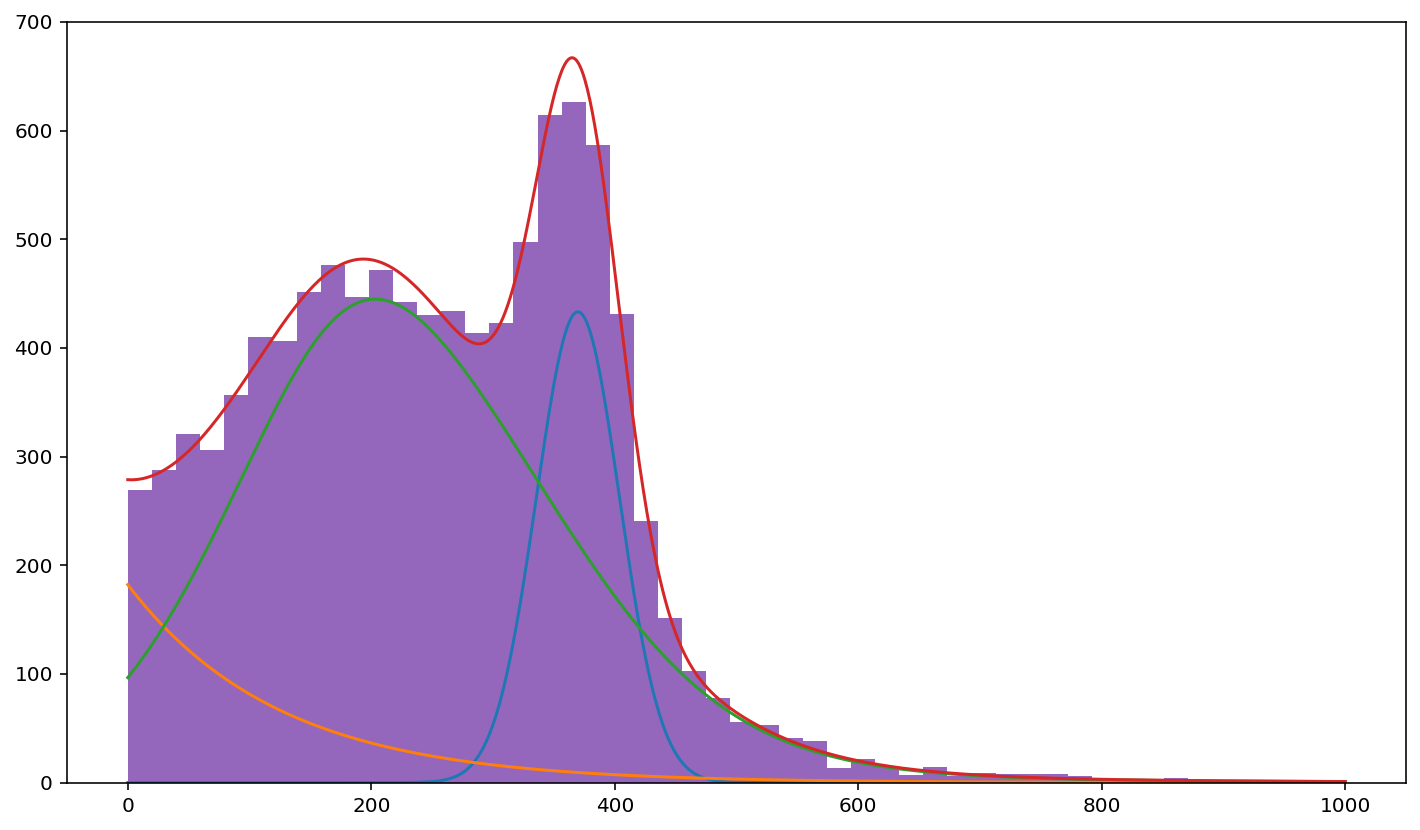

In [52]:
plot_comp_model(model_ext_sum, data)

# Fit result

The result of every minimization is stored in a `FitResult`. This is the last stage of the zfit workflow and serves as the interface to other libraries. Its main purpose is to store the values of the fit, to reference to the objects that have been used and to perform (simple) uncertainty estimation.

In [53]:
print(result)

FitResult

 of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_5, Composed_autoparam_6, Composed_autoparam_7] dtype=float64>0] data=[<zfit.core.data.SampleData object at 0x7f90f5454438>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ 

True

    │ True

        │ False

            │ 0.00013 │ -1.954e+04  │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛



Parameters


name               value    at limit
---------------  -------  ----------
sig_yield           1851       False


comb_bkg_yield      1131       False


part_reco_yield     7018       False


alpha_sig            300       False


mu_sig             369.7       False


n sig                  4       False


sigma_sig          34.09       False

This gives an overview over the whole result. Often we're mostly interested in the parameters and their values, which we can access with a `params` attribute.

In [54]:
print(result.params)

name               value    at limit
---------------  -------  ----------
sig_yield           1851       False


comb_bkg_yield      1131       False


part_reco_yield     7018       False


alpha_sig            300       False


mu_sig             369.7       False


n sig                  4       False


sigma_sig          34.09       False

This is a `dict` which stores any knowledge about the parameters and can be accessed by the parameter (object) itself:

In [55]:
result.params[mu_sig]

{'value': 369.7337120757637}

'value' is the value at the minimum. To obtain other information about the minimization process, `result` contains more attributes:
- fmin: the function minimum
- edm: estimated distance to minimum
- info: contains a lot of information, especially the original information returned by a specific minimizer
- converged: if the fit converged

In [56]:
result.fmin

-19539.388894488584

## Estimating uncertainties

The `FitResult` has mainly two methods to estimate the uncertainty:
- a profile likelihood method (like MINOS)
- Hessian approximation of the likelihood (like HESSE)

When using `Minuit`, this uses (currently) it's own implementation. However, zfit has its own implementation, which are likely to become the standard and can be invoked by changing the method name.

Hesse is also [on the way to implement](https://github.com/zfit/zfit/pull/244) the [corrections for weights](https://inspirehep.net/literature/1762842).

We can explicitly specify which parameters to calculate, by default it does for all.

In [89]:
result.hesse()

OrderedDict([(<zfit.Parameter 'sig_yield' floating=True value=1850>,
              {'error': 73.52924652265973}),
             (<zfit.Parameter 'comb_bkg_yield' floating=True value=1130>,
              {'error': 79.49051306516832}),
             (<zfit.Parameter 'part_reco_yield' floating=True value=7020>,
              {'error': 136.98379193128127}),
             (<zfit.Parameter 'alpha_sig' floating=True value=300>,
              {'error': 141.4213562373095}),
             (<zfit.Parameter 'mu_sig' floating=True value=369.7>,
              {'error': 1.3913704142629884}),
             (<zfit.Parameter 'n sig' floating=True value=4>,
              {'error': 10.069756698215553}),
             (<zfit.Parameter 'sigma_sig' floating=True value=34.09>,
              {'error': 1.3407261987832484})])

In [58]:
# result.hesse(method='hesse_np')

We get the result directly returned. This is also added to `result.params` for each parameter and is nicely displayed with an added column

In [59]:
print(result.params)

name               value    minuit_hesse    at limit
---------------  -------  --------------  ----------
sig_yield           1851     +/-      69       False


comb_bkg_yield      1131     +/-      75       False


part_reco_yield     7018     +/- 1.2e+02       False


alpha_sig            300     +/- 1.4e+02       False


mu_sig             369.7     +/-     1.4       False


n sig                  4     +/-      10       False


sigma_sig          34.09     +/-     1.3       False

In [60]:
errors, new_result = result.errors(params=[sig_yield, part_reco_yield, mu_sig])  # just using three for speed reasons

/home/user/.local/lib/python3.6/site-packages/zfit/minimizers/fitresult.py:359: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  "in the future, add it explicitly as in `errors(method='minuit_minos')`", FutureWarning)


In [61]:
# errors, new_result = result.errors(params=[yield_model, sig_frac, mu_sig], method='zfit_error')

In [62]:
print(errors)

OrderedDict([(<zfit.Parameter 'sig_yield' floating=True value=1851>, MError(name='sig_yield', is_valid=True, lower=-73.19610573010954, upper=73.2494131480733, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=208, min=1850.6452612293656)), (<zfit.Parameter 'part_reco_yield' floating=True value=7018>, MError(name='part_reco_yield', is_valid=True, lower=-134.46090913541406, upper=138.70099174669127, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=204, min=7017.782731457284)), (<zfit.Parameter 'mu_sig' floating=True value=369.7>, MError(name='mu_sig', is_valid=True, lower=-1.3846589189505978, upper=1.391857347531778, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False

In [63]:
print(result.params)

name               value    minuit_hesse         minuit_minos    at limit
---------------  -------  --------------  -------------------  ----------
sig_yield           1851     +/-      69  -     73   +     73       False


comb_bkg_yield      1131     +/-      75                            False


part_reco_yield     7018     +/- 1.2e+02  -1.3e+02   +1.4e+02       False


alpha_sig            300     +/- 1.4e+02                            False


mu_sig             369.7     +/-     1.4  -    1.4   +    1.4       False


n sig                  4     +/-      10                            False


sigma_sig          34.09     +/-     1.3                            False

#### What is 'new_result'?

When profiling a likelihood, such as done in the algorithm used in `errors`, a new minimum can be found. If this is the case, this new minimum will be returned, otherwise `new_result` is `None`. Furthermore, the current `result` would be rendered invalid by setting the flag `valid` to `False`. _Note_: this behavior only applies to the zfit internal error estimator.

### A simple profile

There is no default function (yet) for simple profiling plot. However, again, we're in Python and it's simple enough to do that for a parameter. Let's do it for `sig_yield`

In [64]:
x = np.linspace(1600, 2000, num=50)
y = []
sig_yield.floating = False
for val in x:
    sig_yield.set_value(val)
    y.append(nll.value())

sig_yield.floating = True
zfit.param.set_values(nll.get_params(), result)

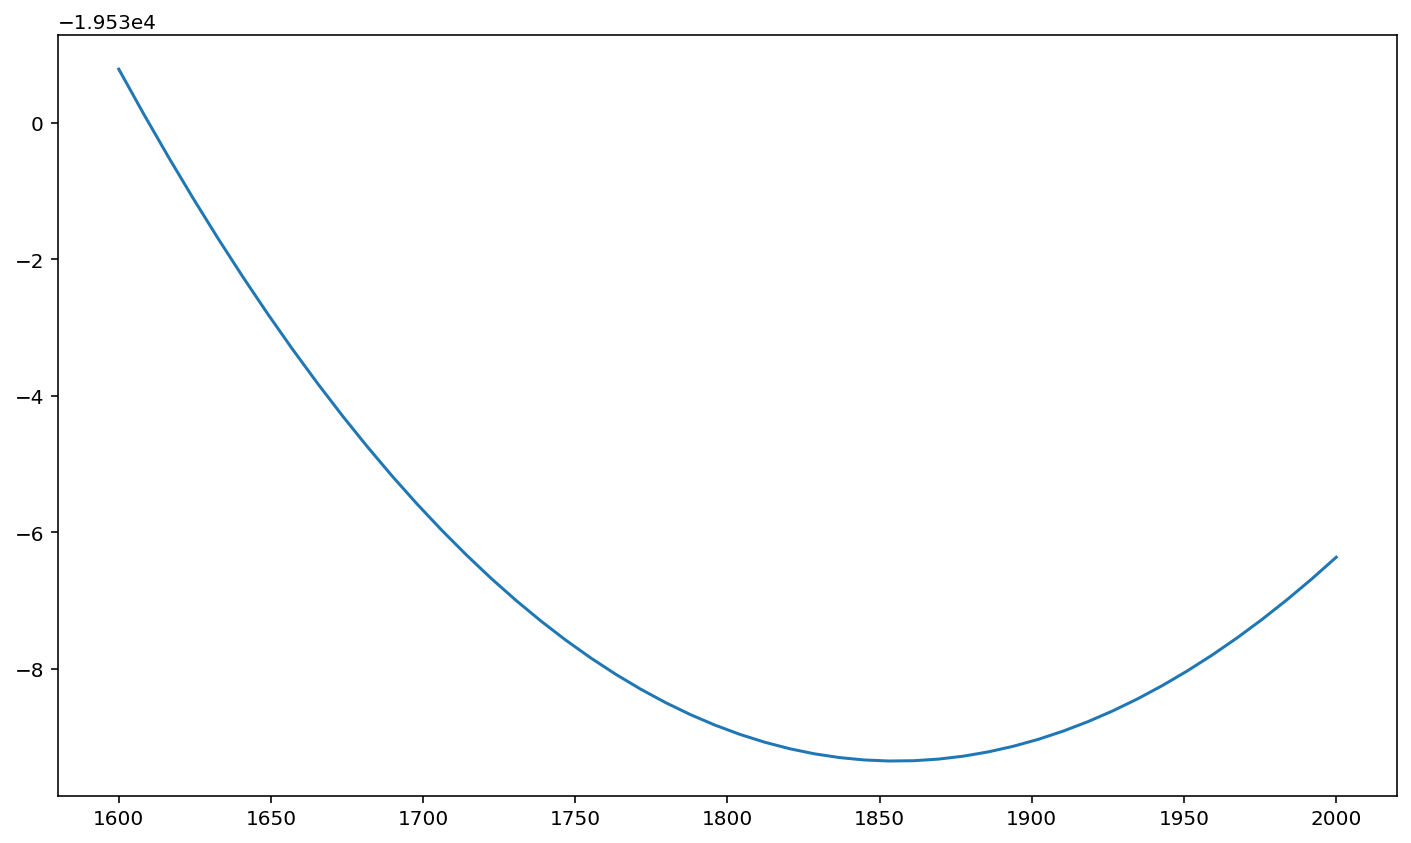

In [65]:
plt.plot(x, y)

We can also access the covariance matrix of the parameters

In [66]:
result.covariance()

array([[ 4.80313887e+03,  1.02095082e+03, -3.43531769e+03,
         0.00000000e+00, -2.08964215e+01,  0.00000000e+00,
         4.67706435e+01],
       [ 1.02095082e+03,  5.63159948e+03, -5.91552419e+03,
         0.00000000e+00, -7.87129146e+00,  0.00000000e+00,
         1.77558437e+01],
       [-3.43531769e+03, -5.91552419e+03,  1.46369813e+04,
         0.00000000e+00,  3.07633305e+01,  0.00000000e+00,
        -6.37418378e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.00000000e+04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.08964215e+01, -7.87129146e+00,  3.07633305e+01,
         0.00000000e+00,  1.93158341e+00,  0.00000000e+00,
        -4.28578345e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.01400000e+02,
         0.00000000e+00],
       [ 4.67706435e+01,  1.77558437e+01, -6.37418378e+01,
         0.00000000e+00, -4.28578345e-01,  0.00000000e+00,
         1.7420527

# End of zfit

This is where zfit finishes and other libraries take over.

# Beginning of hepstats

`hepstats` is a library containing statistical tools and utilities for high energy physics. In particular you do statistical inferences using the models and likelhoods function constructed in `zfit`.

Short example: let's compute for instance a confidence interval at 68 % confidence level on the mean of the gaussian defined above.

In [67]:
from hepstats.hypotests.parameters import POIarray
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import ConfidenceInterval

In [85]:
calculator = AsymptoticCalculator(input=result, minimizer=minimizer)

In [90]:
value = result.params[mu_sig]["value"]
error = result.params[mu_sig]["minuit_hesse"]["error"]

mean_scan = POIarray(mu_sig, np.linspace(value - 1.5*error, value + 1.5*error, 10))

In [91]:
ci = ConfidenceInterval(calculator, mean_scan)

In [92]:
ci.interval()


Confidence interval on mu_sig:
	368.3536149718213 < mu_sig < 371.12167557864825 at 68.0% C.L.

{'observed': 369.7420306479183,
 'upper': 371.12167557864825,
 'lower': 368.3536149718213}

Text(0.5, 0, 'mean')

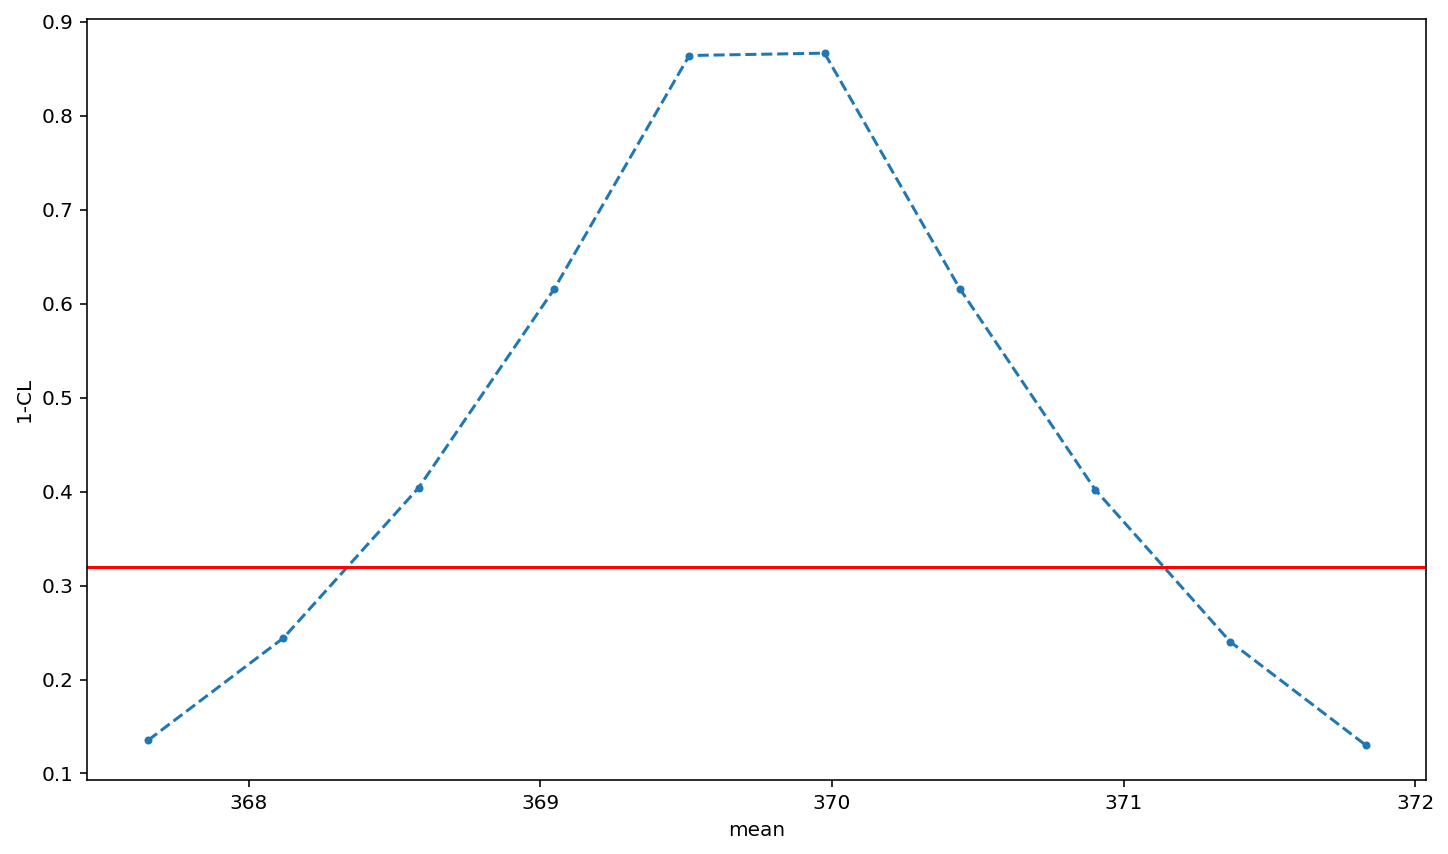

In [93]:
from utils import one_minus_cl_plot

ax = one_minus_cl_plot(ci)
ax.set_xlabel("mean")

There will be more of `hepstats` later.